## Ocean Biogeochemical Dynamics Lab, Spring 2021
Doing simple seasonal decomposition of drivers of DIC and TA with SOCCOM floats by Nancy Williams

This assumes you have already become familiar with `OBD_SOCCOM_L3.ipynb` and `OBD_SOCCOM_CO2SYS.ipynb` notebooks.

SOCCOM website: https://soccom.princeton.edu/

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import seaborn as sns # this will change the look of pandas plots, too
import cartopy.crs as ccrs
import cartopy.feature
import seawater
import xarray as xr
from PyCO2SYS.api import CO2SYS_wrap as co2sys
# this forces matplotlib to print figures out here when you make plots
from IPython.display import Image

In [3]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (15, 9)
plt.rcParams['font.size'] = 18
#plt.rcParams['lines.linewidth'] = 3

In [4]:
# Define the directory where you want the figures to be saved
output_dir = 'generated/'
# you could use os.path.join() which adds slashes

In [5]:
# You can switch this to turn debugging on or off (True or False)
DEBUG = False

def debug (*args):
    """Call print() with arguments if DEBUG is True""" # preserves formatting
    if DEBUG:
        print(*args)

# Importing the dataset
We want to use Pandas' built-in read_csv function to import a single float data file into a pandas data frame called `flt`. Float 9254 is a good example float for this exercise, but you can pick any float from the snapshot. To pick another float you can go to the SOCCOM web page sensor status table http://soccom.ucsd.edu/floats/SOCCOM_sensor_stats.html and choose a float with lots of good data (i.e., more in the "#g" column than the "#b" columns for variables you're interested in analyzing. You can sort the columns on that webpage by clicking on the column header by which you wish to sort.

In [6]:
# Pick a float
floatnum = '9254' 
floatpath = 'SOCCOM_LoResQC_LIAR_22Dec2020_odvtxt/' # This is the folder where all the float data live
floatsuffix = 'SOOCNQC.TXT' # all of the Southern Ocean floats have the same suffix

# Change // comment symbols to #
# input file
fin = open(floatpath+floatnum+floatsuffix,'rt',encoding='UTF-8')

# output file to which we will write the result
fout = open('fltrem.txt','wt')

# this is a for loop
# for each line in the input file
for line in fin:
    # red and replace the string and write to the output file
    fout.write(line.replace('//','#'))
# close the files
fin.close()
fout.close()

flt = pd.read_csv(
    'fltrem.txt',
    delimiter='\t',
    comment='#',
    na_values=-1E10,
)

flt['date'] = pd.to_datetime(flt['mon/day/yr'] + ' ' + flt['hh:mm'])
debug(flt)

In [7]:
# Loop through all Quality Flag columns and apply them to the preceeding columns
from re import search
for column in range(len(flt.columns)):
    name=flt.columns[column]
    if search('QF',name): # if the column is a QF column, apply it to the preceeding column, otherwise go on to next column
        var=flt.columns[column-1]
        flt[var] = np.where(flt.iloc[:,flt.columns.get_loc(var)+1] == 0,flt[var], np.nan)

# Mapping your data
It's always a good idea to map your data and make sure it is where you think it is. Here we will use cartopy (basemap is deprecated).

Since we're talking about the Southern Ocean and there are stark fronts, it's good to plot your data in relation to these fronts. The climatological locations of the fronts are available from Orsi et al. (1995) https://www.sciencedirect.com/science/article/pii/096706379500021W. Text files containing the locations of the fronts are located in the "fronts" folder.

>Orsi, A. H., Whitworth, T. I., & Nowlin, W. D. J. (1995). On the meridional extent and fronts of the Antarctic Circumpolar Current. Deep Sea Research Part I. https://doi.org/10.1016/0967-0637(95)00021-W

### Where is your float in relation to the fronts of the ACC?
The following code imports the longitudes and latitudes of the five fronts. There are some '%' values in the files which creates breaks in the fronts. If we did not keep these breaks, the fronts would plot across continents.

In [8]:
def read_front_csv(name):
    """read Orsi front csv file into pandas dataframe"""
    return pd.read_csv(
        f'fronts/{name}.txt', #fstrings
        header=None,
        sep='\s+',
        na_values='%',
        names=['lon', 'lat'],
    )

stf = read_front_csv('stf')
saf = read_front_csv('saf')
pf = read_front_csv('pf')
saccf = read_front_csv('saccf')
sbdy = read_front_csv('sbdy')

The following is an example of a South Polar Stereographic map using Cartopy https://scitools.org.uk/cartopy/docs/latest/#. Polar stereographic maps are always a bit more complicated because you have to translate your coordinates to polar coordinates.

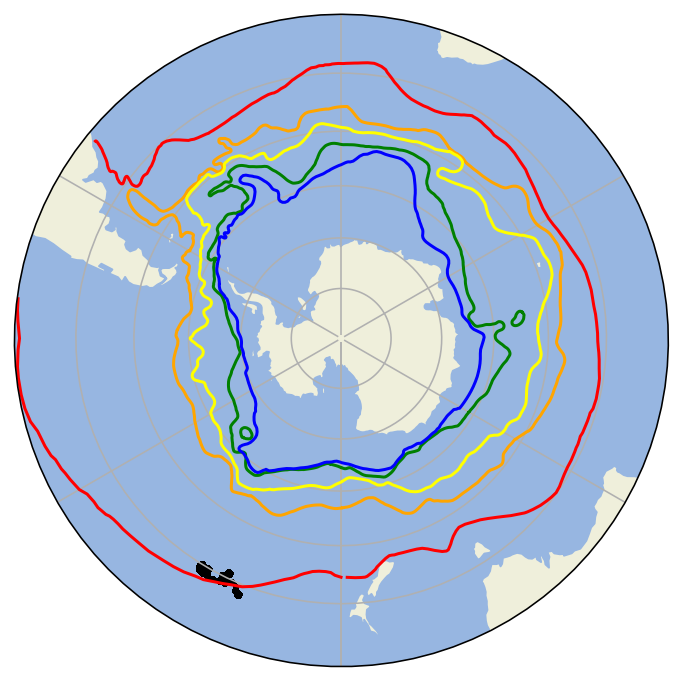

In [9]:
plt.figure(figsize =(6, 6))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180,180,-90,-30], ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.gridlines()

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform = ax.transAxes)
plt.plot(stf['lon'], stf['lat'], color='Red', transform=ccrs.PlateCarree())
plt.plot(saf['lon'], saf['lat'], color='Orange', transform=ccrs.PlateCarree())
plt.plot(pf['lon'], pf['lat'], color='Yellow', transform=ccrs.PlateCarree())
plt.plot(saccf['lon'], saccf['lat'], color='Green', transform=ccrs.PlateCarree())
plt.plot(sbdy['lon'], sbdy['lat'], color='Blue', transform=ccrs.PlateCarree())

plt.scatter(flt['Lon [°E]'],flt['Lat [°N]'], color='Black', transform=ccrs.PlateCarree(), s=1)
plt.savefig(output_dir + 'F' +floatnum + 'map.png') 
plt.show()

In [10]:
# Calculate MLD for each station
MLD = []
for station in flt['Station'].unique():
    surfacedens = flt['Sigma_theta[kg/m^3]'].loc[(flt['Station']==station)].min()
    MLD.append(
        [station,flt['date'].loc[(flt['Station']==station)&
                                 (flt['Sigma_theta[kg/m^3]']-surfacedens>0.03)].min(),
         flt['Depth[m]'].loc[(flt['Station']==station)&
                             (flt['Sigma_theta[kg/m^3]']-surfacedens>0.03)].min(),
         flt['Lon [°E]'].loc[(flt['Station']==station)].mean(),
         flt['Lat [°N]'].loc[(flt['Station']==station)].mean()])

# Take a look at MLD. First column is the Station, second column is datenum, second column is the MLD
MLD = pd.DataFrame(data=MLD, columns=['Station', 'date', 'MLD','Lon [°E]','Lat [°N]'])
debug(MLD)

## Make a time series plot of average mixed layer observations
Here we first pull *only* the data from the mixed layer (shallower than MLD) and put into a separate dataframe called `fltSurf`. We then use the pandas groupby function to group and average the mixed layer data by station.
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html

In [11]:
fltSurf = pd.DataFrame()
for station in flt['Station'].unique():
    stationMLD = MLD.MLD[MLD.Station==station].values[0]
    mask = (flt['Station']==station) & (flt['Pressure[dbar]']<stationMLD)
    fltSurf = fltSurf.append(flt[mask])
debug(fltSurf)

In [12]:
# Use groupby to get average values for each station
fltSurfByStn = fltSurf.groupby('Station', as_index=False).mean()
debug(fltSurfByStn)

In [13]:
# Groupby doesn't work on datetime column so it was dropped. We need to make a datetime array to be used with plotting
fltdates = []
for station in fltSurfByStn['Station'].unique():
    fltdates.append([flt['date'].loc[(flt['Station']==station)].min()])
debug(len(fltdates))
debug(type(fltdates))
fltdates

[[Timestamp('2014-04-21 18:36:00')],
 [Timestamp('2014-04-27 02:13:00')],
 [Timestamp('2014-05-02 09:44:00')],
 [Timestamp('2014-05-07 20:42:00')],
 [Timestamp('2014-05-13 03:04:00')],
 [Timestamp('2014-05-18 11:36:00')],
 [Timestamp('2014-05-23 18:14:00')],
 [Timestamp('2014-05-29 03:23:00')],
 [Timestamp('2014-06-03 11:25:00')],
 [Timestamp('2014-06-08 18:06:00')],
 [Timestamp('2014-06-14 01:15:00')],
 [Timestamp('2014-06-19 08:41:00')],
 [Timestamp('2014-06-24 19:55:00')],
 [Timestamp('2014-06-30 03:07:00')],
 [Timestamp('2014-07-05 09:23:00')],
 [Timestamp('2014-07-10 18:04:00')],
 [Timestamp('2014-07-16 00:39:00')],
 [Timestamp('2014-07-21 06:26:00')],
 [Timestamp('2014-07-26 13:46:00')],
 [Timestamp('2014-07-31 22:53:00')],
 [Timestamp('2014-08-06 06:59:00')],
 [Timestamp('2014-08-11 13:24:00')],
 [Timestamp('2014-08-16 19:46:00')],
 [Timestamp('2014-08-22 02:05:00')],
 [Timestamp('2014-08-27 08:44:00')],
 [Timestamp('2014-09-01 15:52:00')],
 [Timestamp('2014-09-06 22:08:00')],
 

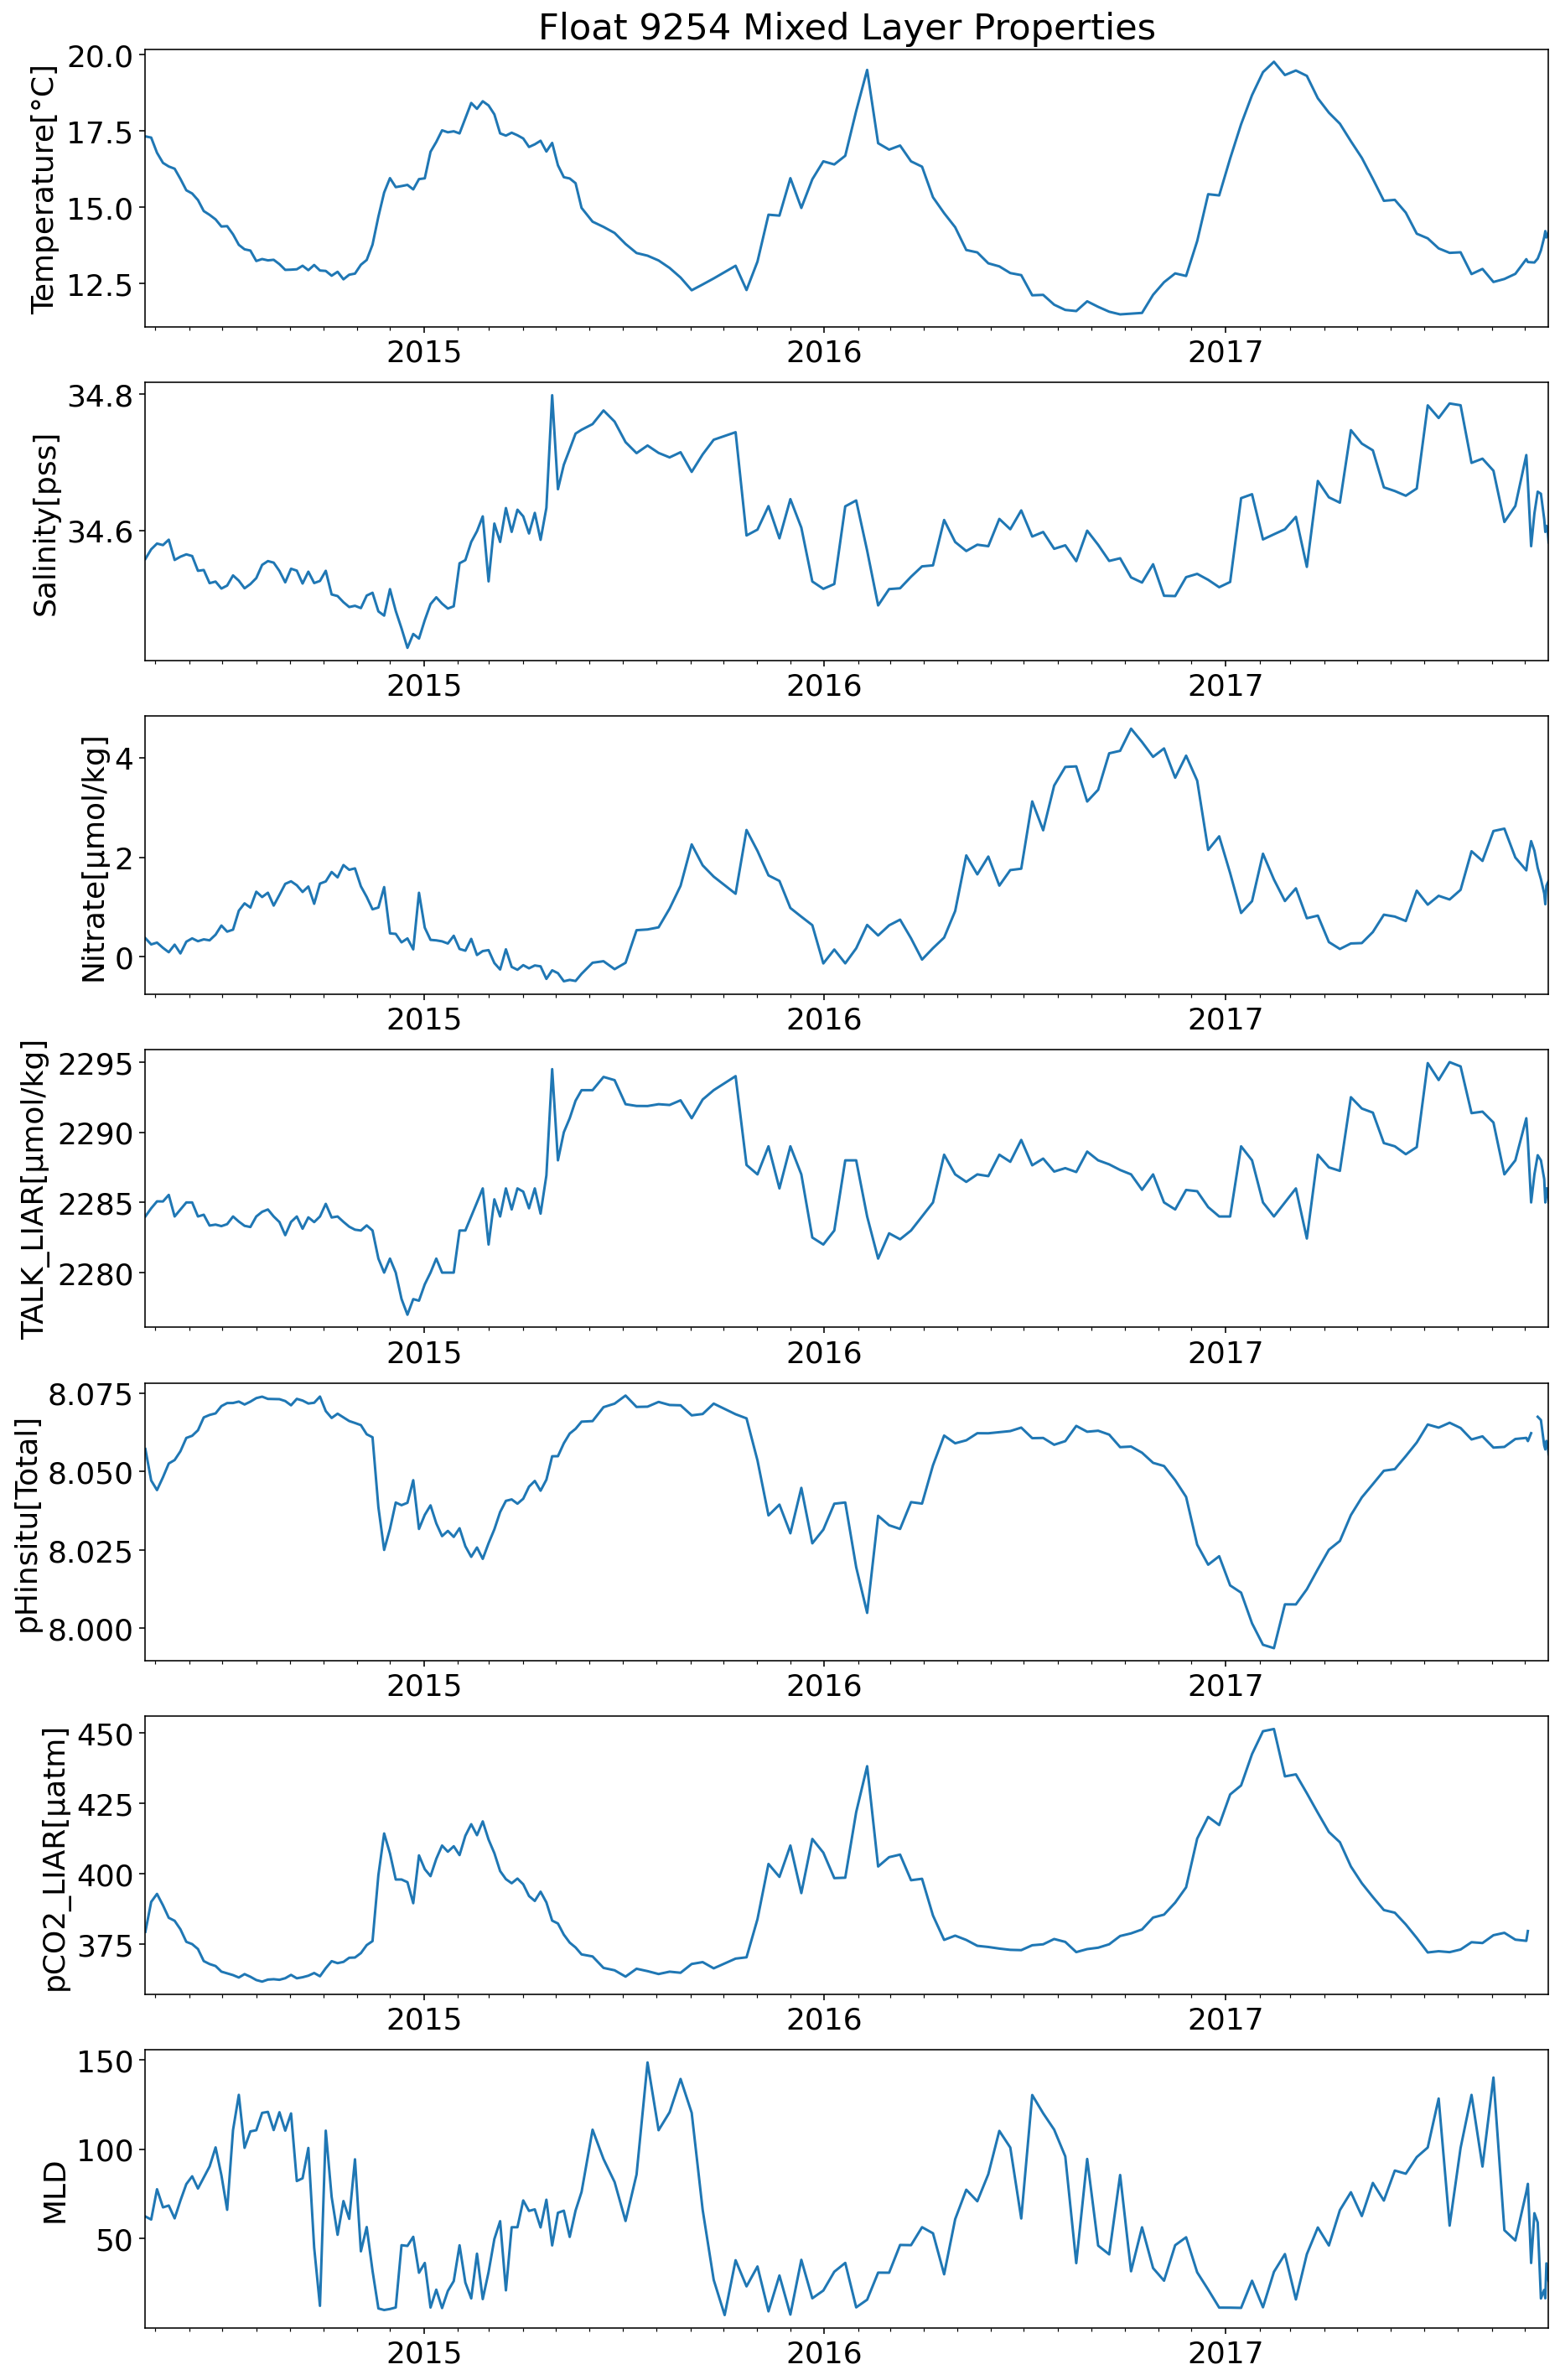

In [14]:
# Make a big plot with subplots
fig,axes = plt.subplots(nrows = 7, ncols = 1,figsize=(15,25))
import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

var='Temperature[°C]'
axes[0].plot(fltdates,fltSurfByStn[var])
axes[0].set_ylabel(var)
axes[0].set_xlim(fltdates[0],fltdates[-1])
axes[0].xaxis.set_major_locator(years)
axes[0].xaxis.set_major_formatter(years_fmt)
axes[0].xaxis.set_minor_locator(months)

var='Salinity[pss]'
axes[1].plot(fltdates,fltSurfByStn[var])
axes[1].set_ylabel(var)
axes[1].set_xlim(fltdates[0],fltdates[-1])
axes[1].xaxis.set_major_locator(years)
axes[1].xaxis.set_major_formatter(years_fmt)
axes[1].xaxis.set_minor_locator(months)

var='Nitrate[µmol/kg]'
axes[2].plot(fltdates,fltSurfByStn[var])
axes[2].set_ylabel(var)
axes[2].set_xlim(fltdates[0],fltdates[-1])
axes[2].xaxis.set_major_locator(years)
axes[2].xaxis.set_major_formatter(years_fmt)
axes[2].xaxis.set_minor_locator(months)

var='TALK_LIAR[µmol/kg]'
axes[3].plot(fltdates,fltSurfByStn[var])
axes[3].set_ylabel(var)
axes[3].set_xlim(fltdates[0],fltdates[-1])
axes[3].xaxis.set_major_locator(years)
axes[3].xaxis.set_major_formatter(years_fmt)
axes[3].xaxis.set_minor_locator(months)

var='pHinsitu[Total]'
axes[4].plot(fltdates,fltSurfByStn[var])
axes[4].set_ylabel(var)
axes[4].set_xlim(fltdates[0],fltdates[-1])
axes[4].xaxis.set_major_locator(years)
axes[4].xaxis.set_major_formatter(years_fmt)
axes[4].xaxis.set_minor_locator(months)

var='pCO2_LIAR[µatm]'
axes[5].plot(fltdates,fltSurfByStn[var])
axes[5].set_ylabel(var)
axes[5].set_xlim(fltdates[0],fltdates[-1])
axes[5].xaxis.set_major_locator(years)
axes[5].xaxis.set_major_formatter(years_fmt)
axes[5].xaxis.set_minor_locator(months)

var='MLD'
axes[6].plot(MLD['date'],MLD['MLD'])
axes[6].set_ylabel(var)
axes[6].set_xlim(fltdates[0],fltdates[-1])
axes[6].xaxis.set_major_locator(years)
axes[6].xaxis.set_major_formatter(years_fmt)
axes[6].xaxis.set_minor_locator(months)

axes[0].set_title('Float ' + floatnum + ' Mixed Layer Properties')
fig.savefig(output_dir + 'F' + floatnum + 'MLD.png', dpi = 200, bbox_inches='tight')

## Mixed layer decomposition
Next, we will do a simple decomposition of the drivers of DIC and TA over the annual cycle. This simple decomposition does not account for the differences between processes which might add/subtract DIC and TA from the mixed layer through physical processes. 

The first step is to use the built in pandas.diff() function to take the differences between each station and the last. This will serve as our "Deltas" or changes in mixed layer depth properties between stations.

In [15]:
Deltas = fltSurfByStn.diff()
debug(Deltas)
debug(fltSurfByStn)

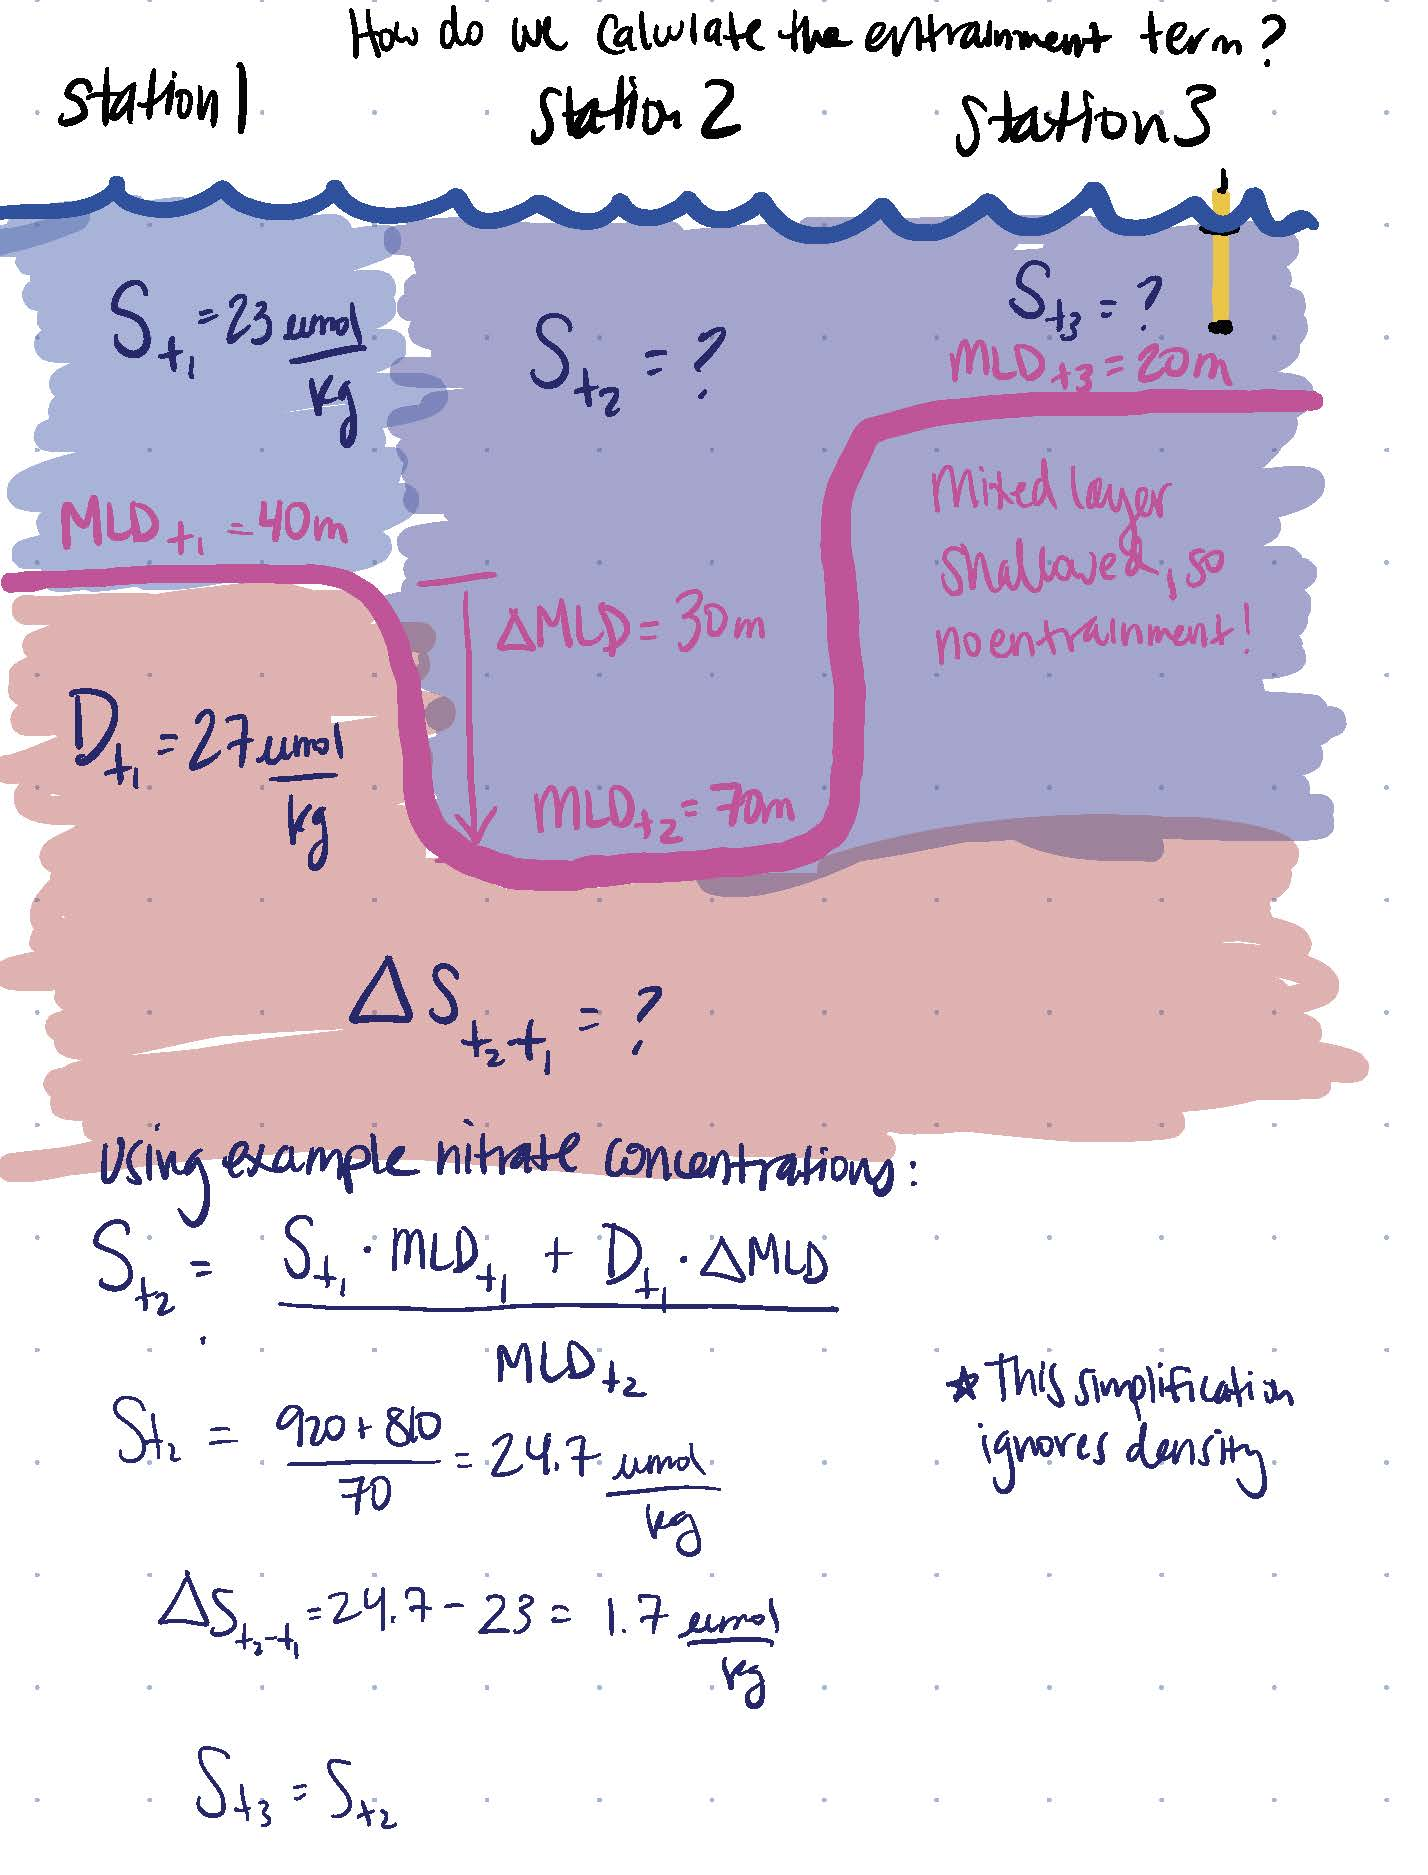

In [21]:
Image('Entrainment.jpg', width=800)

In [24]:
# First let's calculate the sub-mixed layer values
fltSubMLD = pd.DataFrame()
for station in fltSurfByStn['Station'].unique(): 
    stationMLD = MLD.MLD[MLD.Station==station].values[0]
    mask = (flt['Station']==station) & (flt['Pressure[dbar]']>stationMLD) & (flt['Pressure[dbar]']<stationMLD+50)
    # this is not very sensitive to which depth below the mixed layer you choose 
    fltSubMLD = fltSubMLD.append(flt[mask])
debug(fltSubMLD)
fltSubMLDByStn = fltSubMLD.groupby('Station',as_index=False).mean()
debug(fltSubMLDByStn)

In [25]:
# When the mixed layer is deepening (dMLD is positive) calculate dproperty_dMLD terms
dN_dMLD = pd.DataFrame()
dTA_dMLD = pd.DataFrame()
dDIC_dMLD = pd.DataFrame()
for station in fltSurfByStn['Station'].unique():
    if station == 1: # to turn off this block, make it read "if False and ___"
        dN_dMLD = dN_dMLD.append([0], ignore_index=True)
        dTA_dMLD = dTA_dMLD.append([0], ignore_index=True)
        dDIC_dMLD = dDIC_dMLD.append([0], ignore_index=True)
        
        lastSubML = fltSubMLDByStn.loc[fltSubMLDByStn['Station'] == station]
        lastML = fltSurfByStn.loc[fltSurfByStn['Station'] == station]
        lastMLD = MLD.MLD[MLD.Station == station].values[0]
        continue
    
    if (len(lastSubML) == 0) or (len(lastML) == 0):
        dN_dMLD = dN_dMLD.append([0], ignore_index=True)
        dTA_dMLD = dTA_dMLD.append([0], ignore_index=True)
        dDIC_dMLD = dDIC_dMLD.append([0], ignore_index=True)
        
        lastSubML = fltSubMLDByStn.loc[fltSubMLDByStn['Station'] == station]
        lastML = fltSurfByStn.loc[fltSurfByStn['Station'] == station]
        lastMLD = MLD.MLD[MLD.Station == station].values[0]
        continue
    
    MLDt2 = MLD.MLD[MLD.Station == station].values[0]
    dMLD = MLDt2 - lastMLD
    if dMLD > 0: # i.e., only if the mixed layer is deepening
        # Calculate the change in mixed layer content from the entrainment
        # Use the surface mixed layer and sub-mixed layer values from the last station
        dN = ((lastML['Nitrate[µmol/kg]'].values[0] * lastMLD +
               lastSubML['Nitrate[µmol/kg]'].values[0] * dMLD) /
              MLDt2) - lastML['Nitrate[µmol/kg]'].values[0]
        dTA = ((lastML['TALK_LIAR[µmol/kg]'].values[0] * lastMLD +
               lastSubML['TALK_LIAR[µmol/kg]'].values[0] * dMLD) /
              MLDt2) - lastML['TALK_LIAR[µmol/kg]'].values[0]
        dDIC = ((lastML['DIC_LIAR[µmol/kg]'].values[0] * lastMLD +
               lastSubML['DIC_LIAR[µmol/kg]'].values[0] * dMLD) /
              MLDt2) - lastML['DIC_LIAR[µmol/kg]'].values[0]
        
        #dN = [(A['Nitrate[µmol/kg]'].values[0] - B['Nitrate[µmol/kg]'].values[0]) * dMLD / MLDt1]
        #dTA = [(A['TALK_LIAR[µmol/kg]'].values[0] - B['TALK_LIAR[µmol/kg]'].values[0]) * dMLD / MLDt2]
        #dDIC = [(A['DIC_LIAR[µmol/kg]'].values[0] - B['DIC_LIAR[µmol/kg]'].values[0]) * dMLD / MLDt2]
        
        debug (station, dMLD, dN)
        
        dN_dMLD = dN_dMLD.append(pd.DataFrame([dN]), ignore_index=True)
        dTA_dMLD = dTA_dMLD.append(pd.DataFrame([dTA]), ignore_index=True)
        dDIC_dMLD = dDIC_dMLD.append(pd.DataFrame([dDIC]), ignore_index=True)
        
        lastSubML = fltSubMLDByStn.loc[fltSubMLDByStn['Station'] == station]
        lastML = fltSurfByStn.loc[fltSurfByStn['Station'] == station]
        lastMLD = MLD.MLD[MLD.Station == station].values[0]
      
    else:
        dN_dMLD = dN_dMLD.append([0], ignore_index=True)
        dTA_dMLD = dTA_dMLD.append([0], ignore_index=True)
        dDIC_dMLD = dDIC_dMLD.append([0], ignore_index=True)
        
        lastSubML = fltSubMLDByStn.loc[fltSubMLDByStn['Station'] == station]
        lastML = fltSurfByStn.loc[fltSurfByStn['Station'] == station]
        lastMLD = MLD.MLD[MLD.Station == station].values[0]

In [26]:
#Check that the dproperty_dMLD terms are all the same length
debug(len(dN_dMLD), len(dTA_dMLD), len(dDIC_dMLD))

In [27]:
dN_dS = Deltas['Salinity[pss]'] * fltSurfByStn['Nitrate[µmol/kg]'].iloc[0] / fltSurfByStn['Salinity[pss]'].iloc[0]
dTA_dS = Deltas['Salinity[pss]'] * fltSurfByStn['TALK_LIAR[µmol/kg]'].iloc[0] / fltSurfByStn['Salinity[pss]'].iloc[0]
dDIC_dS = Deltas['Salinity[pss]'] * fltSurfByStn['DIC_LIAR[µmol/kg]'].iloc[0] / fltSurfByStn['Salinity[pss]'].iloc[0]

debug(dDIC_dS)

In [28]:
# Net Community Metabolism (respiration - photosynthesis)

# Squeeze turns this dataframe into a series so we can do math with it and these other series
dN_NCM = Deltas['Nitrate[µmol/kg]'] - dN_dS - dN_dMLD.squeeze() 
C_to_N = 117 / 16
TA_to_N = -16 / 16
dDIC_NCM = dN_NCM * C_to_N
dTA_NCM = dN_NCM * TA_to_N

debug(dDIC_NCM)

In [29]:
# Calcification and Dissolution
dTA_CaCO3 = Deltas['TALK_LIAR[µmol/kg]'] - dTA_dS - dTA_NCM - dTA_dMLD.squeeze()
DIC_to_TA_calc = 0.5
dDIC_CaCO3 = dTA_CaCO3 * DIC_to_TA_calc

debug(dTA_CaCO3)

In [30]:
# Residual term- this represents physics that we didn't explicitly account for, and gas exchange
dDIC_resid = Deltas['DIC_LIAR[µmol/kg]'] - dDIC_dS - dDIC_NCM - dDIC_CaCO3 - dDIC_dMLD.squeeze()
dDIC_resid

0           NaN
1      6.489073
2      2.750470
3      1.587081
4     -0.923393
         ...   
166    2.897631
167    1.191814
168   -1.728019
169   -0.324342
170    0.458895
Length: 171, dtype: float64

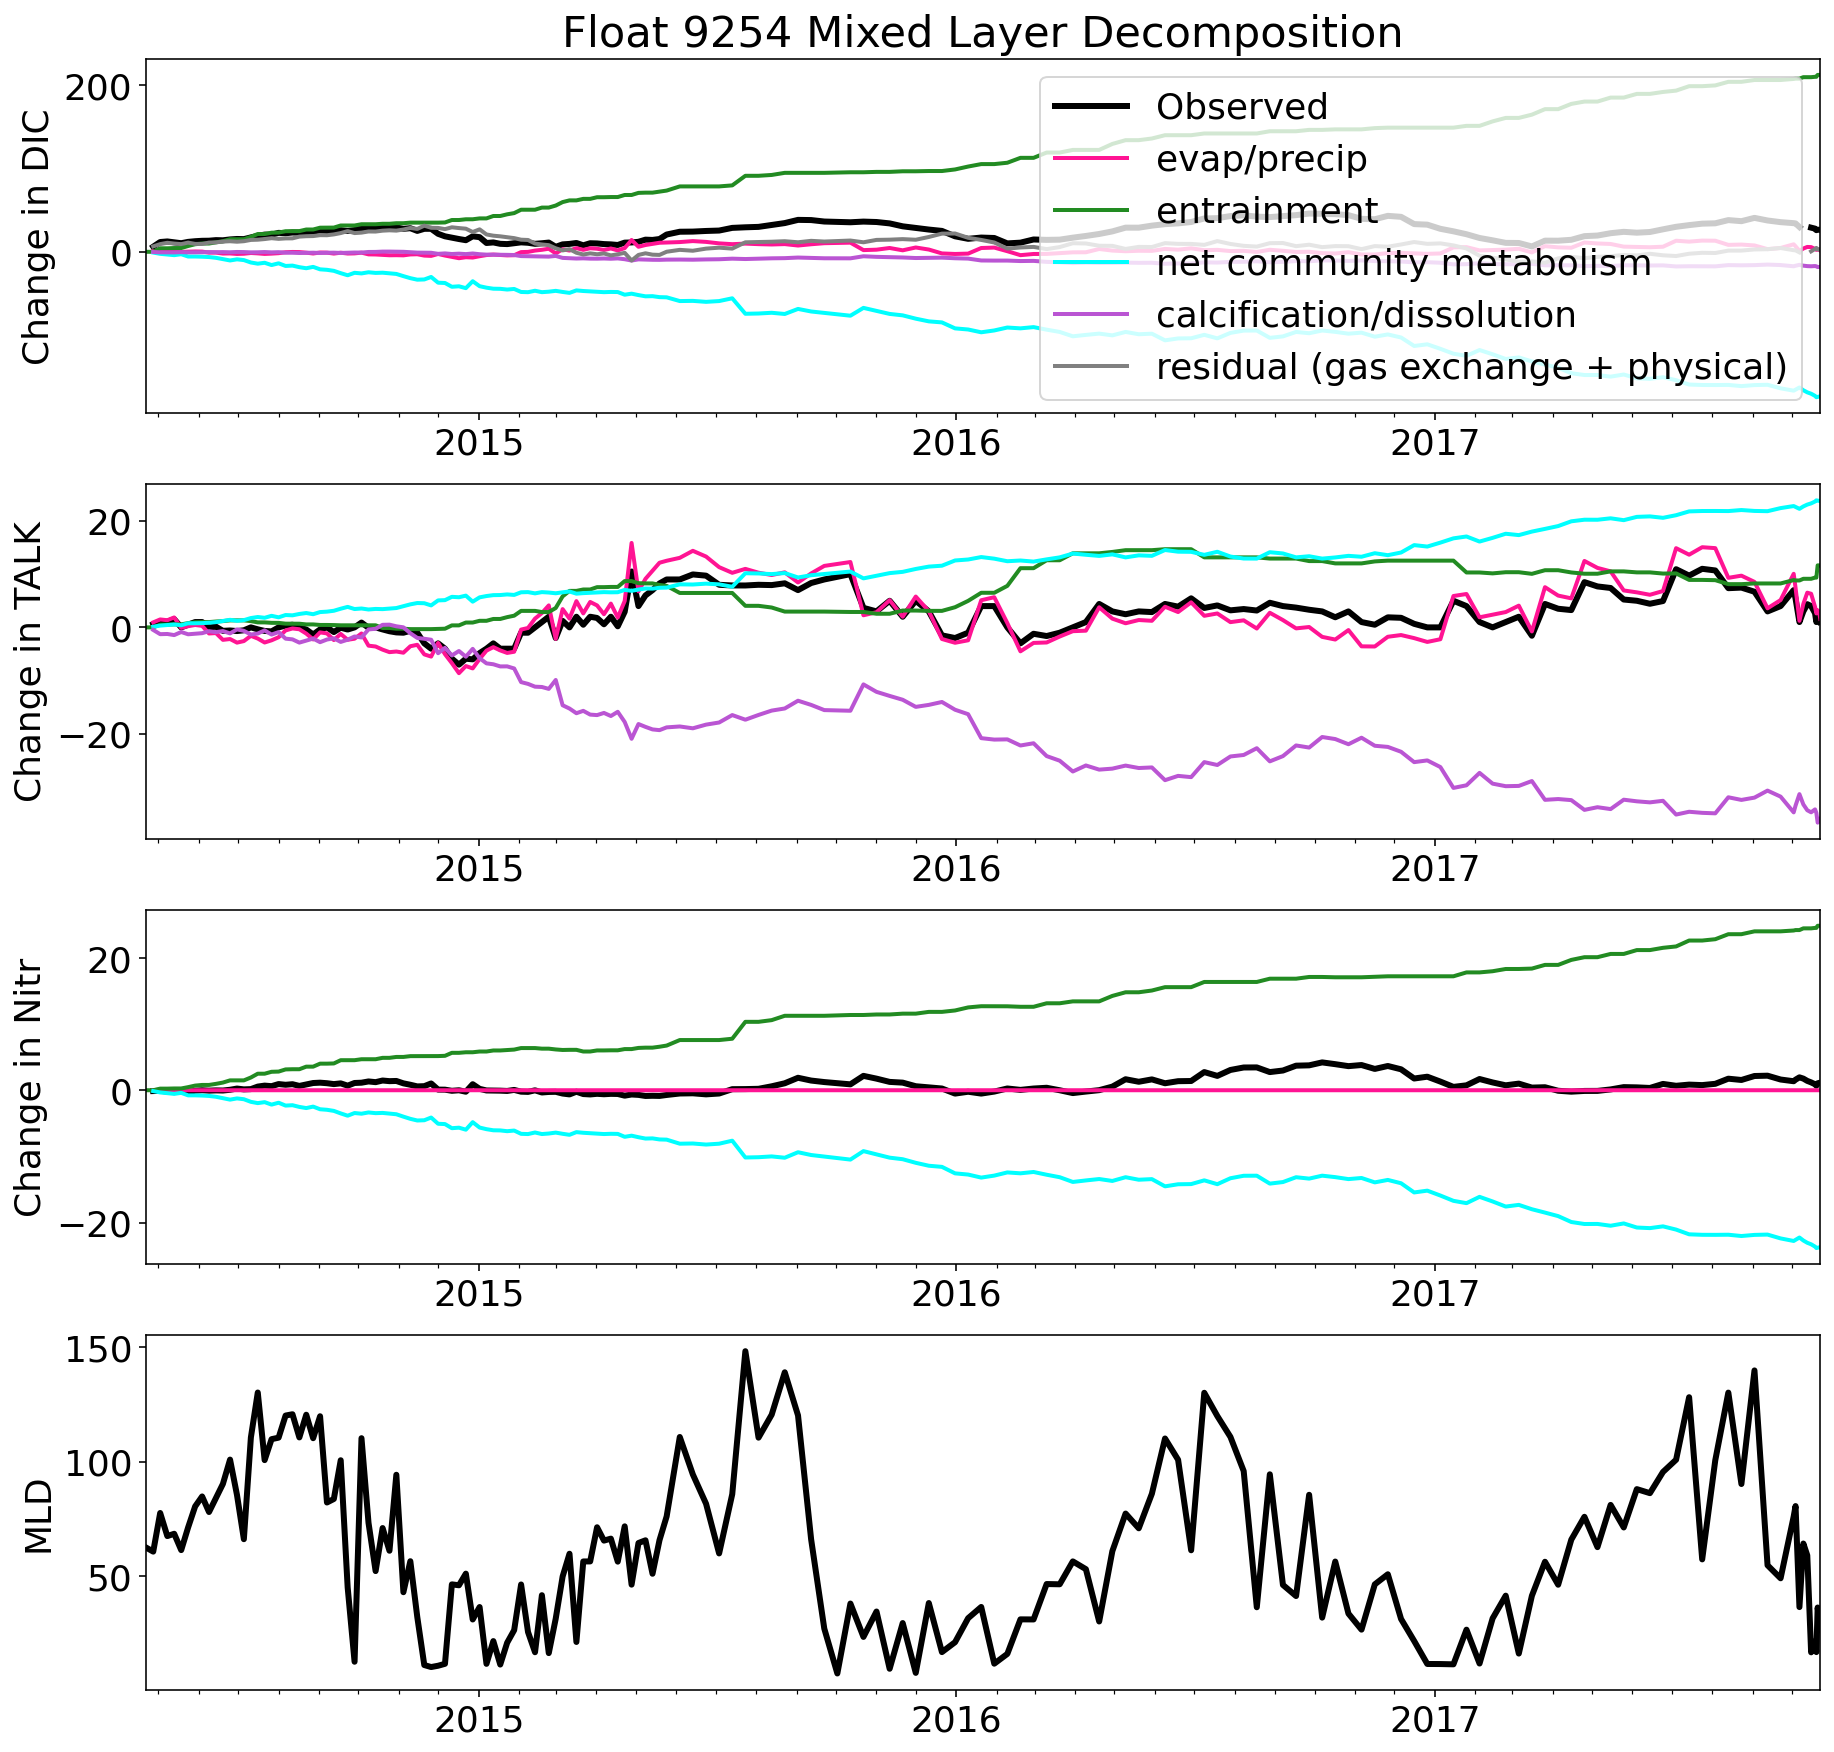

In [31]:
# Make a big plot with subplots
fig,axes = plt.subplots(nrows = 4, ncols = 1,figsize=(15,15))
import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

var='DIC_LIAR[µmol/kg]'
axes[0].plot(fltdates,Deltas[var].cumsum(), label='Observed', c='black', linewidth=3)
axes[0].set_ylabel('Change in ' + var[:3])
axes[0].plot(fltdates,dDIC_dS.cumsum(), label='evap/precip', c='deeppink', linewidth=2)
axes[0].plot(fltdates,dDIC_dMLD[0].cumsum(), label='entrainment', c='forestgreen', linewidth=2)
axes[0].plot(fltdates,dDIC_NCM.cumsum(), label='net community metabolism', c='cyan', linewidth=2)
axes[0].plot(fltdates,dDIC_CaCO3.cumsum(), label='calcification/dissolution', c='mediumorchid', linewidth=2)
axes[0].plot(fltdates,dDIC_resid.cumsum(), label='residual (gas exchange + physical)', c='grey', linewidth=2)
axes[0].set_xlim(fltdates[0], fltdates[-1])
axes[0].xaxis.set_major_locator(years)
axes[0].xaxis.set_major_formatter(years_fmt)
axes[0].xaxis.set_minor_locator(months)
axes[0].legend()

var='TALK_LIAR[µmol/kg]'
axes[1].plot(fltdates,Deltas[var].cumsum(), label='Observed', c='black', linewidth=3)
axes[1].set_ylabel('Change in ' + var[:4])
axes[1].plot(fltdates,dTA_dS.cumsum(), label='evap/precip', c='deeppink', linewidth=2)
axes[1].plot(fltdates,dTA_dMLD[0].cumsum(), label='entrainment', c='forestgreen', linewidth=2)
axes[1].plot(fltdates,dTA_NCM.cumsum(), label='net community metabolism', c='cyan', linewidth=2)
axes[1].plot(fltdates,dTA_CaCO3.cumsum(), label='calcification/dissolution', c='mediumorchid', linewidth=2)
axes[1].set_xlim(fltdates[0], fltdates[-1])
axes[1].xaxis.set_major_locator(years)
axes[1].xaxis.set_major_formatter(years_fmt)
axes[1].xaxis.set_minor_locator(months)
#axes[1].legend()

var = 'Nitrate[µmol/kg]'
axes[2].plot(fltdates,Deltas[var].cumsum(), label='Observed', c='black', linewidth=3)
axes[2].set_ylabel('Change in ' + var[:4])
axes[2].plot(fltdates,dN_dS.cumsum(), label='evap/precip', c='deeppink', linewidth=2)
axes[2].plot(fltdates,dN_dMLD[0].cumsum(), label='entrainment', c='forestgreen', linewidth=2)
axes[2].plot(fltdates,dN_NCM.cumsum(), label='net community metabolism', c='cyan', linewidth=2)
axes[2].set_xlim(fltdates[0], fltdates[-1])
axes[2].xaxis.set_major_locator(years)
axes[2].xaxis.set_major_formatter(years_fmt)
axes[2].xaxis.set_minor_locator(months)
#axes[2].legend()

var = 'MLD'
axes[3].plot(MLD['date'],MLD['MLD'], label='Observed', c='black', linewidth=3)
axes[3].set_ylabel(var)
axes[3].set_xlim(fltdates[0], fltdates[-1])
axes[3].xaxis.set_major_locator(years)
axes[3].xaxis.set_major_formatter(years_fmt)
axes[3].xaxis.set_minor_locator(months)

axes[0].set_title('Float ' + floatnum + ' Mixed Layer Decomposition')
fig.savefig(output_dir + 'F' + floatnum + 'MLDecomp.png', dpi = 200, bbox_inches='tight')